<center>
  <h2>Trabajo Laboratorio de Implementación III - MCD Virtual Cohorte 2022</h2>
  <h3>Forecasting para una Empresa de Consumo Masivo</h3>
  <h4>Inferencias</h4>
</center>

In [50]:
# Importación librerias

# !pip install awswrangler
# !pip install boto3
import boto3
import awswrangler as wr
import pandas as pd
import numpy as np
from datetime import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Definición fechas

date_start=datetime.strptime('2017-01-01', '%Y-%m-%d')
date_end=datetime.strptime('2019-12-01', '%Y-%m-%d')
forecast_length = 2
date_future=date_end+relativedelta(months=forecast_length)
years=range(2018, 2020)

print(f"Fecha inicio historia {date_start}")
print(f"Fecha fin historia {date_end}")
print(f"Fecha futura (related time series) {date_future}")

# Versión modelo
data_version = '1'
grouped_columns = ["product_id"]
grouped_cols_name = "product"

# Parametros backtest
dataset_frequency='M'
quantiles=["mean"]

Fecha inicio historia 2017-01-01 00:00:00
Fecha fin historia 2019-12-01 00:00:00
Fecha futura (related time series) 2020-02-01 00:00:00


In [3]:
# Conexiones AWS

account_id=boto3.client('sts').get_caller_identity().get('Account')
session = boto3.Session() 
forecast = session.client(service_name='forecast')
region = forecast.meta.region_name
forecastquery = session.client(service_name='forecastquery')
role = f'arn:aws:iam::{account_id}:role/ForecastRole'

In [4]:
# Buckets de datos

# Data
target_s3_path=f's3://datasets-forecast/modelo-{data_version}-forecast-{grouped_cols_name}/target/df_ventas_{grouped_cols_name}.csv'
items_s3_path=f's3://datasets-forecast/modelo-{data_version}-forecast-{grouped_cols_name}/product/df_products.csv'
related_s3_path=f's3://datasets-forecast/modelo-{data_version}-forecast-{grouped_cols_name}/related/df_related_{grouped_cols_name}.csv'

# Outputs
backtest_export_path=f's3://datasets-forecast/modelo-{data_version}-forecast-{grouped_cols_name}/output/'

In [5]:
# Formar ARNs

dataset_group_arn=f'arn:aws:forecast:us-east-1:{account_id}:dataset-group/modelo_{data_version}_{grouped_cols_name}'
# Se busca de la notebook 3
codigo_predictor = '01HZG49YKVPFHRYBPFZPG3KTYK'
automl_predictor_arn = f'arn:aws:forecast:us-east-1:{account_id}:predictor/modelo_{data_version}_predictor_{codigo_predictor}'

In [6]:
# Verificar comunicación con Amazon Forecast
assert forecast.list_predictors()

In [7]:
best_quantile = ["mean"]

### Generar inferencias

Se hizo desde UI de forecast

### Exportar resultados

Se hizo desde UI de forecast

In [8]:
export_s3_path=f's3://datasets-forecast/modelo-{data_version}-forecast-{grouped_cols_name}/inferencias/'

### Lectura de forecasts

In [35]:
df_predictions=wr.s3.read_csv(export_s3_path)

In [36]:
len(df_predictions.drop_duplicates(subset="item_id"))

780

In [37]:
for i in best_quantile:
    df_predictions[i]=np.where(df_predictions[i]<0, 0, df_predictions[i])
df_predictions.head(5)

,item_id,brand,cat1,cat2,cat3,sku_size,date,mean
0,20158,mayos3,foods,aderezos,ketchup,240,2020-01-01T00:00:00Z,49.092519
1,20158,mayos3,foods,aderezos,ketchup,240,2020-02-01T00:00:00Z,54.656519
2,20219,musculo,hc,hogar,vidrios,500,2020-01-01T00:00:00Z,25.344498
3,20219,musculo,hc,hogar,vidrios,500,2020-02-01T00:00:00Z,25.574621
4,20428,maggi,foods,sopas y caldos,sopas,5,2020-01-01T00:00:00Z,2.738729


In [38]:
df_predictions.date.unique()

array(['2020-01-01T00:00:00Z', '2020-02-01T00:00:00Z'], dtype=object)

In [39]:
df_predictions = df_predictions[["date", "item_id", "mean"]]
df_predictions = df_predictions.rename(columns = {"date": "periodo", "item_id":"product_id", "mean":"tn"})
df_predictions["product_id"] = df_predictions["product_id"].astype(str)

In [40]:
len(df_predictions.product_id.unique())

780

In [41]:
df_predictions.head(5)

,periodo,product_id,tn
0,2020-01-01T00:00:00Z,20158,49.092519
1,2020-02-01T00:00:00Z,20158,54.656519
2,2020-01-01T00:00:00Z,20219,25.344498
3,2020-02-01T00:00:00Z,20219,25.574621
4,2020-01-01T00:00:00Z,20428,2.738729


In [42]:
df_predictions_concat = df_predictions.copy()
df_predictions_concat['periodo']=pd.to_datetime(df_predictions_concat['periodo'], format='%Y-%m-%dT%H:%M:%SZ').dt.date
df_predictions_concat['periodo']=pd.to_datetime(df_predictions_concat['periodo'])
df_predictions_concat.head(5)

,periodo,product_id,tn
0,2020-01-01,20158,49.092519
1,2020-02-01,20158,54.656519
2,2020-01-01,20219,25.344498
3,2020-02-01,20219,25.574621
4,2020-01-01,20428,2.738729


- Read historic sales data

In [43]:
# Leer el archivo CSV sin encabezado
df_ventas_mensuales = pd.read_csv("C:/Users/usuario/otros/Desktop/MCD/6 Labo III/Forecasting Problem/Datasets/df_ventas_product.csv", header=None, index_col=False)
column_names = ["periodo"] + grouped_columns + ["venta"]
df_ventas_mensuales.columns = column_names
df_ventas_mensuales['periodo'] = pd.to_datetime(df_ventas_mensuales['periodo'])
df_ventas_mensuales['product_id']=df_ventas_mensuales['product_id'].astype(str)
df_ventas_mensuales.head(5)

,periodo,product_id,venta
0,2017-01-01,20001,934.77222
1,2017-01-01,20002,550.15707
2,2017-01-01,20003,1063.45835
3,2017-01-01,20004,555.91614
4,2017-01-01,20005,494.27011


In [44]:
df_ventas_mensuales.dtypes

periodo       datetime64[ns]
product_id            object
venta                float64
dtype: object

- Unión info histórica y forecast

In [45]:
df_predictions_concat.dtypes

periodo       datetime64[ns]
product_id            object
tn                   float64
dtype: object

In [46]:
df_ventas_mensuales.dtypes

periodo       datetime64[ns]
product_id            object
venta                float64
dtype: object

In [52]:
# Para los meses en los que coexiste venta real con forecast se realiza un merge outer
df_forecasts_historic=pd.concat([df_ventas_mensuales, df_predictions_concat])
df_forecasts_historic=df_forecasts_historic.rename(columns={"tn":"mean"})
df_forecasts_historic.head(5)

,periodo,product_id,venta,mean
0,2017-01-01,20001,934.77222,NaN
1,2017-01-01,20002,550.15707,NaN
2,2017-01-01,20003,1063.45835,NaN
3,2017-01-01,20004,555.91614,NaN
4,2017-01-01,20005,494.27011,NaN


- Graficos

In [53]:
def graficar_producto(df, product_id):
    # Filtrar los datos para un producto específico
    filtered_data = df[df["product_id"] == product_id]
    filtered_data['periodo'] = pd.to_datetime(filtered_data['periodo'])

    # Crear una figura y ejes
    plt.figure(figsize=(10, 6))

    # Graficar la serie de tiempo de ventas
    sns.lineplot(data=filtered_data, x="periodo", y="venta", marker="x", label="Venta")
    # Graficar la serie de tiempo de medias
    sns.lineplot(data=filtered_data, x="periodo", y="mean", marker="o", label="Forecast")

    # Añadir título y etiquetas
    plt.title("Serie de tiempo de ventas y medias para el producto {}".format(product_id))
    plt.xlabel("Mes")
    plt.ylabel("Venta / Forecast")

    # Mostrar la leyenda
    plt.legend(title="Variable", loc="upper left")

    # Mostrar el gráfico
    return plt.show()

C:\Users\usuario\AppData\Local\Temp\ipykernel_16700\2745594770.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['periodo'] = pd.to_datetime(filtered_data['periodo'])


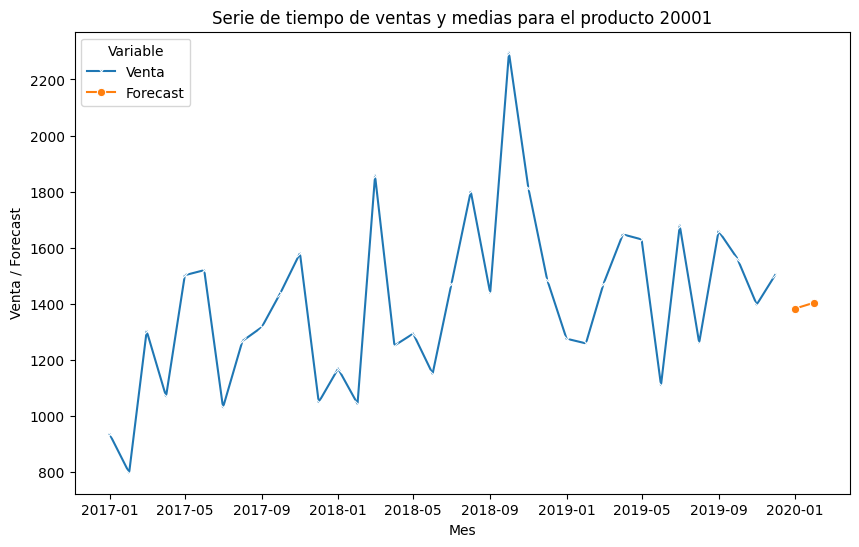

In [54]:
graficar_producto(df_forecasts_historic, product_id = "20001")

C:\Users\usuario\AppData\Local\Temp\ipykernel_16700\2745594770.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['periodo'] = pd.to_datetime(filtered_data['periodo'])


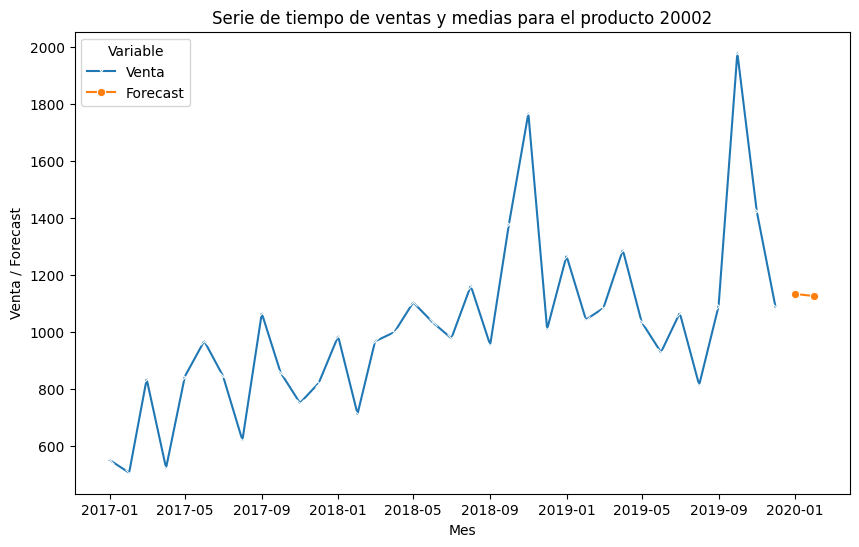

In [55]:
graficar_producto(df_forecasts_historic, product_id = "20002")

- Exportamos

In [ ]:
df_predictions = df_predictions[df_predictions.periodo == '2020-02-01T00:00:00Z']
print(df_predictions.periodo.unique())
df_predictions.head(5)
df_predictions.to_csv(f"C:/Users/usuario/otros/Desktop\MCD/6 Labo III/Forecasting Problem/Outputs/prediccion_modelo{data_version}_AWS.csv", sep = ",", index = False)